# Лабораторная работа 1# Лабораторная работа 1

Самостоятельно написать код, реализующий искусственный нейрон с сигма-функцией активации, и возможность строить на его основе многослойные сети. \
Код должен также реализовывать градиентный спуск и обратное распространение ошибки.

На основе вашего кода:
1. Решить задачу  классификации датаcета Iris одним нейроном.
2. Решить задачу  классификации датаcета Iris одним  нейросетью из 2 слоев по 10 нейронов в слое.
3. Отрисовать разделяющую линию для обеих моделей. Сравнить метрики классификации.

Добавил дополнительно обучение батчами, решение MNIST

In [1]:
import numpy as np

### Функция активации

Сигмоид

In [2]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)


<img src="assets/sigmoid.png" width="600">

### Нейрон

In [3]:
class Neuron:
    def __init__(self, n_inputs, weight_scale = 0.1):
        self.w = np.random.randn(n_inputs) * weight_scale
        self.b = 0.0
        
    def forward(self, x: np.ndarray):
        z = float(np.dot(self.w, x) + self.b)
        return sigmoid(z)

<img src="assets/perceptron.png" width="600">

### Слой нейронов

Для реализации слоя нейронов лучше не использовать класс нейрона.\
Используем линейную алгебру \
Для слоя с N входами и M нейронами (будут иметь N весов) будем хранить матрицу весов W: M строк и N столбцов. А также вектор B (M строк). \
В строке i матрицы весов будут веса i выходного нейрона. \
Перемножим на входные значения: \
W*x + B \
Для i нейрона: \
w_1\*x_1 + ... + w_n\*x_n + b \
Получили произведение весов i нейрона на входные значения + b \
То есть на выходе мы получим результаты для каждого нейрона. \
Далее можем применить функцию активации и отправить этот вектор в следующий слой 

Эта реализация требует транспонирования входных значения X если они представлены в виде [[признак1, ...], [признак1, ...], ...] \
На 2 картинке немного другая реализация, которая более удобна и используется в Keras/TensorFlow/PyTorch для входных значений X

<div>
<img src="assets/nn_layer.jpg" width="400">
<img src="assets/layer2.png" width="450">
</div>

In [4]:
class Layer:
    def __init__(self, n_inputs, n_neurons, activation, activation_derivative):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.activation = activation
        self.activation_derivative = activation_derivative
        
        # 1
        # self.W = np.random.randn(n_neurons, n_inputs) * np.sqrt(2 / n_inputs)
        # self.b = np.zeros((n_neurons, 1))
        
        # 2
        self.W = np.random.randn(n_inputs, n_neurons) * np.sqrt(2 / n_inputs)
        self.b = np.zeros((1, n_neurons))
        
        # Кэш для обратного распространения
        self.A_prev = None
        self.Z = None
        self.A = None
    
    def forward(self, A_prev):
        self.A_prev = A_prev
        # 1
        # self.Z = self.W @ A_prev + self.b # размерность (n_neurons, m)
        # 2
        self.Z = self.A_prev @ self.W + self.b # размерность (m, n_neurons)
        self.A = self.activation(self.Z)
        return self.A
        

### Функция потерь

In [5]:
def mse(Y_pred, Y):
    return np.mean((Y_pred - Y)**2)

def mse_derivative(Y_pred, Y):
    return 2*(Y_pred - Y)

In [6]:
def bce(Y_pred, Y):
    eps = 1e-8
    return -np.mean(Y * np.log(Y_pred + eps) + (1 - Y) * np.log(1 - Y_pred + eps))

def bce_derivative(Y_pred, Y):
    eps = 1e-8
    return -(Y / (Y_pred + eps)) + ((1 - Y) / (1 - Y_pred + eps))

### Нейронная сеть

In [72]:
class NeuralNetwork:
    def __init__(self, n_inputs, learning_rate, epochs, loss_func, loss_func_derivative):
        self.n_inputs = n_inputs
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.layer_sizes = [n_inputs]
        self.layers = []
        self.loss_func = loss_func
        self.loss_func_derivative = loss_func_derivative
        
    def addLayer(self, n_neurons, activation, activation_derivative):
        layer = Layer(self.layer_sizes[-1], n_neurons, activation, activation_derivative)
        self.layers.append(layer)
        self.layer_sizes.append(n_neurons)

    def forward(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def backward(self, Y_pred, Y):
        m = len(Y)
        dA = self.loss_func_derivative(Y_pred, Y)
        
        for i, layer in enumerate(reversed(self.layers)):
            # dL/dZ
            # для последнего слоя, если применять в конце softmax
            if i == 0 and layer.activation_derivative is None:
                dZ = dA
            else:
                dZ = dA * layer.activation_derivative(layer.Z)

            # dL/dW и dL/db
            # dW = (dZ @ layer.A_prev.T) / m 
            # db = np.sum(dZ, axis=1, keepdims=True) / m
            dW = (layer.A_prev.T @ dZ) / m # (n_inputs, m) @ (m, n_neurons)
            db = np.sum(dZ, axis=0, keepdims=True) / m

            # обновление dL/dA
            # dA = layer.W.T @ dZ
            dA = dZ @ layer.W.T # (m, n_neurons) @ (n_neurons, n_inputs)
            
            # градиентный спуск
            layer.W -= self.learning_rate * dW
            layer.b -= self.learning_rate * db

    def train(self, X, Y):
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)
        
        for i in range(self.epochs):
            Y_pred = self.forward(X)
            loss = self.loss_func(Y_pred, Y)
            self.backward(Y_pred, Y)
        
            if i%100 == 0:
                print("Epoch", i, "Loss:", loss)


    # добавил позже, чтобы применить для MNIST
    def train_v2(self, X, Y, batch_size=64, shuffle=True):
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)
    
        n_samples = X.shape[0]
        for epoch in range(self.epochs):
            if shuffle:
                indices = np.random.permutation(n_samples)
                X = X[indices]
                Y = Y[indices]
    
            epoch_loss = 0
    
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
    
                X_batch = X[start:end]
                Y_batch = Y[start:end]
    
                Y_pred = self.forward(X_batch)
                loss = self.loss_func(Y_pred, Y_batch)
                self.backward(Y_pred, Y_batch)
    
                epoch_loss += loss
    
            epoch_loss /= (n_samples // batch_size)
    
            if epoch % 1 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    
    def predict(self, X):
        return self.forward(X)
    

### Как происходит обучение. Обратное распространение и градиентный спуск

У нас есть обучающий набор данных: \
X: [[...], ... , [...]] - наблюдения \
Y: [...] - результаты \
Применим прямое распространение: \
Y_pred: [...] - предсказание 

##### Пусть задана функия потерь (ошибок) Loss function
L(Y_pred, Y) \
Нам нужно минимизировать это значение: \
min(L)

##### Что происходит в одном слое
Z = W*A_prev + b (или A_prev\*W ) (1)\
A = activate(Z) \
A_prev - это активация предыдующего слоя

#### Идея обратного распространения
Так как L зависит от A, A зависит от Z, Z зависит от W \
то dL/dW = (dL/dA)\*(dA/dZ)\*(dZ/dW) \
- dL/dA - производная функции потерь 
- dA/dZ - производная функции активации
- dZ/dW - производная Z по весам

Идём по слоям в обратном порядке \
В начале: \
DA = dL/dA = L_derivative(A, Y) 

DZ = dL/dZ = (dL/dA)*(dA/dZ) = DA * layer.activation_derivative(layer.Z) \
Из (1) получим dZ/dW = A_prev \
dL/dW = dL/dZ * dZ/dW = DZ * A_prev^T / m (для 2: A_prev^T * DZ) \
(транспонируем чтобы размерность была как у W, у DZ (n_neurons, m) а у A_prev (n_inputs, m) ) \
(для 2 случая: у DZ (m, n_neurons) а у A_prev (m, n_inputs) )

Для смещения b: \
dZ/db = 1 \
dL/db = Sum(DZ) * 1 / m

Обновим DA = dL/dA = dL/dA_prev \
из (1) \
dZ/dA_prev = W \
dL/dA_prev = (dL/dZ) * (dZ/dA_prev) = W^T * DZ (для 2: DZ * W^T) \
(транспонируем чтобы размерность была как у A_prev, у W (n_neurons, n_inputs) а у DZ (n_neurons, m) ) \
(для 2 случая: у W (n_inputs, n_neurons) а у DZ (m, n_neurons) )

##### Градиентный спуск. Обновляем веса и b
W -= learning_rate * dL/dW \
b -= learning_rate * dL/db \
learning_rate - скорость обучения, гиперпараметр

#### Тестирование. XOR

In [38]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([0, 1, 1, 0])

nn = NeuralNetwork(
    n_inputs=2, 
    learning_rate=0.5, 
    epochs=2000,
    loss_func=bce,
    loss_func_derivative=bce_derivative
)
nn.addLayer(2, activation=sigmoid, activation_derivative=sigmoid_derivative)
nn.addLayer(1, activation=sigmoid, activation_derivative=sigmoid_derivative)

nn.train(X, Y)
print(nn.predict(X))


Epoch 0 Loss: 0.7297821829283044
Epoch 100 Loss: 0.6937815315431548
Epoch 200 Loss: 0.6926528420699194
Epoch 300 Loss: 0.6909389516332403
Epoch 400 Loss: 0.6860617846101067
Epoch 500 Loss: 0.6690173778682137
Epoch 600 Loss: 0.6170532581195071
Epoch 700 Loss: 0.5014191282736571
Epoch 800 Loss: 0.29187621963398397
Epoch 900 Loss: 0.15465886215573468
Epoch 1000 Loss: 0.09644285745811648
Epoch 1100 Loss: 0.06810557010720386
Epoch 1200 Loss: 0.05199934615017281
Epoch 1300 Loss: 0.041789212119207664
Epoch 1400 Loss: 0.034802308866632894
Epoch 1500 Loss: 0.029747724531981008
Epoch 1600 Loss: 0.025934469661789764
Epoch 1700 Loss: 0.02296231292702463
Epoch 1800 Loss: 0.02058462908452844
Epoch 1900 Loss: 0.018641706249642155
[[0.01988732]
 [0.98507504]
 [0.9843944 ]
 [0.01710159]]


## Датасет Iris

In [9]:
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
iris = load_iris()
X = iris.data
Y = iris.target

Нормализация

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Бинарная классификация

Не берем в качестве классификации Setosa, так как этот класс линейно разделим и задача очень простая и не интересная, и даже 1 нейрон с ней легко справится. \
Возьмем лучше Versicolor

versicolor (1) и не versicolor (0)

In [12]:
Y = (Y == 1).astype(int)

Разделение на обучающий и тестовый набор

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42,
)

### 1 нейрон

Это однослойный перцептрон (без скрытых слоев) или, по сути, логистическая регрессия.

4 входных признака => 1 выходной нейрон


In [39]:
iris_nn_one = NeuralNetwork(
    n_inputs=4,
    learning_rate=0.1,
    epochs=5000,
    loss_func=bce,
    loss_func_derivative=bce_derivative
)

iris_nn_one.addLayer(
    1,
    activation=sigmoid,
    activation_derivative=sigmoid_derivative
)

iris_nn_one.train(X_train, Y_train)

Epoch 0 Loss: 0.7635772374724422
Epoch 100 Loss: 0.5133413746853496
Epoch 200 Loss: 0.4950763366376007
Epoch 300 Loss: 0.4886804317908146
Epoch 400 Loss: 0.4855746191793717
Epoch 500 Loss: 0.4838453184878088
Epoch 600 Loss: 0.4828117065553801
Epoch 700 Loss: 0.48216204736984836
Epoch 800 Loss: 0.48173411218777046
Epoch 900 Loss: 0.4814379757984645
Epoch 1000 Loss: 0.4812220998560682
Epoch 1100 Loss: 0.4810563353455634
Epoch 1200 Loss: 0.48092277758821145
Epoch 1300 Loss: 0.48081065192921635
Epoch 1400 Loss: 0.4807133868119781
Epoch 1500 Loss: 0.4806269126558097
Epoch 1600 Loss: 0.4805486618898231
Epoch 1700 Loss: 0.48047697590200195
Epoch 1800 Loss: 0.4804107507601504
Epoch 1900 Loss: 0.48034922427021537
Epoch 2000 Loss: 0.4802918472898004
Epoch 2100 Loss: 0.4802382055591821
Epoch 2200 Loss: 0.48018797196645924
Epoch 2300 Loss: 0.4801408772218422
Epoch 2400 Loss: 0.48009669170691704
Epoch 2500 Loss: 0.48005521413001
Epoch 2600 Loss: 0.48001626434078115
Epoch 2700 Loss: 0.47997967869617

In [40]:
Y_pred = iris_nn_one.predict(X_test)
Y_hat = (Y_pred > 0.5).astype(int)

print(confusion_matrix(Y_test.flatten(), Y_hat.flatten()))
print(classification_report(Y_test.flatten(), Y_hat.flatten()))

[[29  3]
 [ 7  6]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.85        32
           1       0.67      0.46      0.55        13

    accuracy                           0.78        45
   macro avg       0.74      0.68      0.70        45
weighted avg       0.77      0.78      0.76        45



Accuracy: ~0.78

Высокое количество False Negative результатов (False Negatives = 7). 
Это означает, что 7 реальных примеров класса 1 были ошибочно отнесены к классу 0. Это привело к низкому Recall (полноте) для класса 1: 6/(7+6)≈0.46.

### 2 слоя по 10 нейронов

Это многослойный перцептрон (MLP) с двумя скрытыми слоями, который позволяет модели изучать сложные нелинейные зависимости.

4 признака => 10 => 10 => 1

In [41]:
iris_nn_10 = NeuralNetwork(
    n_inputs=4,
    learning_rate=0.1,
    epochs=4000,
    loss_func=bce,
    loss_func_derivative=bce_derivative
)

iris_nn_10.addLayer(10, sigmoid, sigmoid_derivative)
iris_nn_10.addLayer(10, sigmoid, sigmoid_derivative)
iris_nn_10.addLayer(1, sigmoid, sigmoid_derivative)

iris_nn_10.train(X_train, Y_train)


Epoch 0 Loss: 0.7258564910810832
Epoch 100 Loss: 0.6239025738102689
Epoch 200 Loss: 0.5903345378531278
Epoch 300 Loss: 0.5588992862979227
Epoch 400 Loss: 0.5295975989938402
Epoch 500 Loss: 0.5037792740464818
Epoch 600 Loss: 0.48207068533337044
Epoch 700 Loss: 0.4639381136339666
Epoch 800 Loss: 0.4481214544941402
Epoch 900 Loss: 0.43331247591132466
Epoch 1000 Loss: 0.4185378429726473
Epoch 1100 Loss: 0.40319382941111903
Epoch 1200 Loss: 0.38692878376085166
Epoch 1300 Loss: 0.36952216182763636
Epoch 1400 Loss: 0.3508184607435548
Epoch 1500 Loss: 0.3307264798832454
Epoch 1600 Loss: 0.3092792395703683
Epoch 1700 Loss: 0.28673085245452506
Epoch 1800 Loss: 0.26361597714915014
Epoch 1900 Loss: 0.24068922707410267
Epoch 2000 Loss: 0.21876674298105542
Epoch 2100 Loss: 0.198556062861388
Epoch 2200 Loss: 0.18052635385776303
Epoch 2300 Loss: 0.16485290160256755
Epoch 2400 Loss: 0.15145681078391407
Epoch 2500 Loss: 0.1401050614980674
Epoch 2600 Loss: 0.13050666888927248
Epoch 2700 Loss: 0.122373579

In [42]:
Y_pred = iris_nn_10.predict(X_test)
Y_hat = (Y_pred > 0.5).astype(int)

print(confusion_matrix(Y_test.flatten(), Y_hat.flatten()))
print(classification_report(Y_test.flatten(), Y_hat.flatten()))

[[32  0]
 [ 1 12]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.96      0.97        45
weighted avg       0.98      0.98      0.98        45



Accuracy: ~0.98

Модель совершила всего 1 ошибку (False Negative = 1).

Значительно улучшена полнота (Recall) для класса 1: 0.92.

Вывод: Добавление скрытых слоев позволило модели построить нелинейную разделяющую границу, которая гораздо точнее отделяет класс Iris-versicolor от остальных.

### Визуализация границы в 2D

In [18]:
def plot_decision_boundary(model, X, Y, feature_idx=(0, 1), title=""):
    i, j = feature_idx

    # Диапазоны
    x_min, x_max = X[:, i].min() - 1, X[:, i].max() + 1
    y_min, y_max = X[:, j].min() - 1, X[:, j].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    # Подготовка входа для модели
    X_grid = np.zeros((xx.size, X.shape[1]))

    X_grid[:, i] = xx.ravel()
    X_grid[:, j] = yy.ravel()

    # Предсказания
    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    # Отрисовка
    plt.figure(figsize=(7, 6))

    plt.contourf(
        xx, yy, Z > 0.5,
        alpha=0.3
    )

    plt.scatter(
        X[Y == 0, i],
        X[Y == 0, j],
        c="blue",
        label="class 0",
        edgecolor="k"
    )

    plt.scatter(
        X[Y == 1, i],
        X[Y == 1, j],
        c="red",
        label="class 1",
        edgecolor="k"
    )

    plt.xlabel(f"feature {i}")
    plt.ylabel(f"feature {j}")
    plt.title(title)
    plt.legend()
    plt.show()

Выбираем 2 признака и визуализируем границу

Это не настоящая граница, а всего лишь срез в 2D. Настоящая граница в 4D.

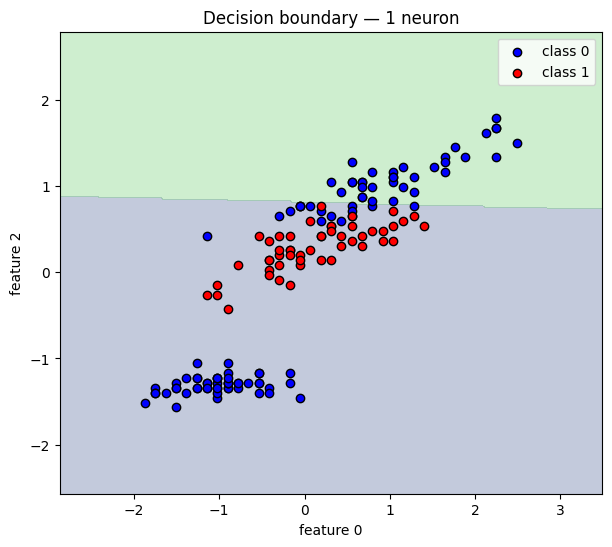

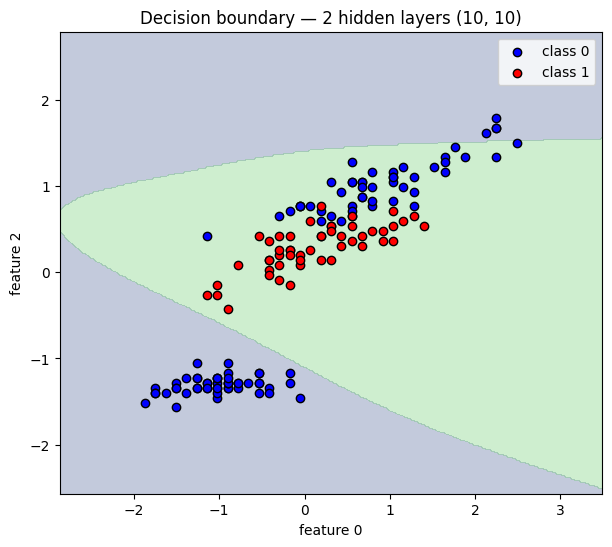

In [19]:
feature_idx = (0, 2)
plot_decision_boundary(iris_nn_one, X, Y, feature_idx=feature_idx, title="Decision boundary — 1 neuron")
plot_decision_boundary(iris_nn_10, X, Y, feature_idx=feature_idx, title="Decision boundary — 2 hidden layers (10, 10)")

### Визуализация границы в 3D

In [20]:
import plotly.graph_objects as go


def plot_decision_boundary_3d_plotly(
    model,
    X,
    Y,
    feature_idx=(0, 1, 2),
    grid_size=35,
    eps=0.02,
    title=""
):
    i, j, k = feature_idx

    x_min, x_max = X[:, i].min() - 1, X[:, i].max() + 1
    y_min, y_max = X[:, j].min() - 1, X[:, j].max() + 1
    z_min, z_max = X[:, k].min() - 1, X[:, k].max() + 1

    xx, yy, zz = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        np.linspace(z_min, z_max, grid_size)
    )

    X_grid = np.zeros((xx.size, X.shape[1]))

    X_grid[:, i] = xx.ravel()
    X_grid[:, j] = yy.ravel()
    X_grid[:, k] = zz.ravel()

    preds = model.predict(X_grid).reshape(xx.shape)

    mask = np.abs(preds - 0.5) < eps

    fig = go.Figure()

    # class 0
    fig.add_trace(go.Scatter3d(
        x=X[Y == 0, i],
        y=X[Y == 0, j],
        z=X[Y == 0, k],
        mode="markers",
        marker=dict(size=4, color="blue"),
        name="class 0"
    ))

    # class 1
    fig.add_trace(go.Scatter3d(
        x=X[Y == 1, i],
        y=X[Y == 1, j],
        z=X[Y == 1, k],
        mode="markers",
        marker=dict(size=4, color="red"),
        name="class 1"
    ))

    # decision boundary
    fig.add_trace(go.Scatter3d(
        x=xx[mask],
        y=yy[mask],
        z=zz[mask],
        mode="markers",
        marker=dict(size=2, color="green", opacity=0.4),
        name="decision boundary (p≈0.5)"
    ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=f"feature {i}",
            yaxis_title=f"feature {j}",
            zaxis_title=f"feature {k}",
        ),
        width=800,
        height=600
    )

    fig.show()


In [21]:
feature_idx = (1, 2, 3)

# plot_decision_boundary_3d_plotly(
#     iris_nn_one,
#     X,
#     Y,
#     feature_idx=feature_idx,
#     title="1 neuron"
# )

# plot_decision_boundary_3d_plotly(
#     iris_nn_10,
#     X,
#     Y,
#     feature_idx=feature_idx,
#     title="2 hidden layers (10,10)"
# )

Скриншоты, так как Plotly не будет показываться в GitHub

<div>
<img src="assets/3d_decision_boundary_1.png" width="800">
<img src="assets/3d_decision_boundary_10.png" width="800">
</div>

### Сравнение

| Метрика             | 1 нейрон | 10–10  |
| ------------------- | -------- | -------- |
| Accuracy            | **0.78** | **0.98** |
| Precision (class 1) | **0.67** | **1.00** |
| Recall (class 1)    | **0.46** | **0.92** |
| F1-score (class 1)  | **0.55** | **0.96** |
| Macro avg F1        | **0.70** | **0.97** |
| Weighted avg F1     | **0.76** | **0.98** |

Линейная модель с одним нейроном показала accuracy 78%, однако recall для класса versicolor составил лишь 46%, что означает потерю более половины объектов данного класса. Это указывает на невозможность линейного разделения классов в пространстве признаков Iris.

Сеть с двумя скрытыми слоями (10–10) значительно улучшила результаты: accuracy достигла 98%, а recall для класса versicolor — 92%. Высокие значения precision и F1-score свидетельствуют о корректном и устойчивом разделении классов.

Таким образом, увеличение сложности модели позволило аппроксимировать нелинейную границу принятия решений и существенно повысить качество классификации.

### Дополнительно. MNIST

In [26]:
from sklearn.datasets import fetch_openml

In [51]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = y.astype(int)

In [45]:
def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=1, keepdims=True)  # числовая стабильность
    expZ = np.exp(Z_shifted)
    return expZ / np.sum(expZ, axis=1, keepdims=True)
    
def cce(Y_pred, Y_true):
    eps = 1e-9
    Y_pred = np.clip(Y_pred, eps, 1 - eps)
    return -np.mean(np.sum(Y_true * np.log(Y_pred), axis=1))

def cce_derivative(Y_pred, Y_true):
    return Y_pred - Y_true

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)


In [77]:
mnist_nn = NeuralNetwork(
    n_inputs=784,
    learning_rate=0.01,
    epochs=100,
    loss_func=cce,
    loss_func_derivative=cce_derivative
)


mnist_nn.addLayer(16, relu, relu_derivative)
mnist_nn.addLayer(16, relu, relu_derivative)
mnist_nn.addLayer(10, softmax, None)

In [78]:
Y = np.eye(10)[y]
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(70000, 10))

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

In [80]:
mnist_nn.train_v2(X_train, Y_train, batch_size=64, shuffle=True)

Epoch 0, Loss: 1.1888
Epoch 1, Loss: 0.5009
Epoch 2, Loss: 0.3895
Epoch 3, Loss: 0.3427
Epoch 4, Loss: 0.3139
Epoch 5, Loss: 0.2925
Epoch 6, Loss: 0.2753
Epoch 7, Loss: 0.2620
Epoch 8, Loss: 0.2499
Epoch 9, Loss: 0.2398
Epoch 10, Loss: 0.2305
Epoch 11, Loss: 0.2228
Epoch 12, Loss: 0.2157
Epoch 13, Loss: 0.2100
Epoch 14, Loss: 0.2037
Epoch 15, Loss: 0.1990
Epoch 16, Loss: 0.1939
Epoch 17, Loss: 0.1900
Epoch 18, Loss: 0.1856
Epoch 19, Loss: 0.1818
Epoch 20, Loss: 0.1786
Epoch 21, Loss: 0.1759
Epoch 22, Loss: 0.1726
Epoch 23, Loss: 0.1700
Epoch 24, Loss: 0.1669
Epoch 25, Loss: 0.1646
Epoch 26, Loss: 0.1622
Epoch 27, Loss: 0.1598
Epoch 28, Loss: 0.1577
Epoch 29, Loss: 0.1554
Epoch 30, Loss: 0.1539
Epoch 31, Loss: 0.1516
Epoch 32, Loss: 0.1491
Epoch 33, Loss: 0.1478
Epoch 34, Loss: 0.1460
Epoch 35, Loss: 0.1443
Epoch 36, Loss: 0.1426
Epoch 37, Loss: 0.1418
Epoch 38, Loss: 0.1395
Epoch 39, Loss: 0.1383
Epoch 40, Loss: 0.1367
Epoch 41, Loss: 0.1355
Epoch 42, Loss: 0.1341
Epoch 43, Loss: 0.132

In [84]:
Y_pred = mnist_nn.predict(X_test)
y_pred_labels = np.argmax(Y_pred, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)

accuracy = np.mean(y_pred_labels == y_true_labels)
print("Accuracy:", accuracy)
print(classification_report(y_pred_labels, y_true_labels)) 

Accuracy: 0.9524761904761905
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2063
           1       0.98      0.97      0.98      2391
           2       0.94      0.95      0.94      2114
           3       0.94      0.95      0.94      2138
           4       0.95      0.94      0.95      1958
           5       0.93      0.96      0.94      1863
           6       0.98      0.95      0.96      2157
           7       0.96      0.95      0.96      2285
           8       0.94      0.95      0.94      1969
           9       0.93      0.94      0.94      2062

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000

